In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import tqdm
import spacepy.toolbox as tb
import seaborn as sns
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats


%matplotlib inline

In [2]:
# http://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-93-1179

* Shots are fired isotropically from a point and hit a position sensitive detector
* There is no scattering
* y is fixed to be 1 away

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 0.29071:   1%|          | 2413/200000 [00:00<00:16, 12303.51it/s]
Convergence archived at 2800
Interrupted at 2,800 [1%]: Average Loss = 0.31913
100%|██████████| 10500/10500 [00:16<00:00, 624.90it/s]


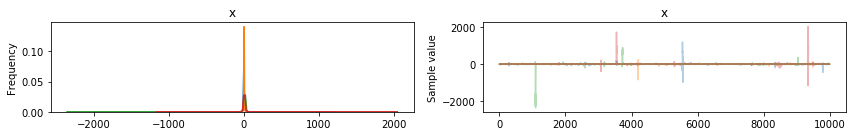

In [3]:
# generate some data
with pm.Model() as model:
    x = pm.Cauchy(name='x', alpha=0, beta=1)
    trace = pm.sample(10000, njobs=4)
    pm.traceplot(trace)
sampledat = trace['x']

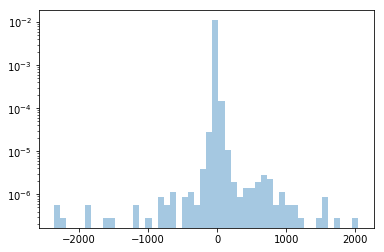

In [4]:
trace.varnames, trace['x']
sns.distplot(sampledat, kde=False, norm_hist=True)
# plt.hist(sampledat, 200, normed=True);
plt.yscale('log');


In [5]:
np.random.randint(0, len(sampledat), 10)

array([25986, 26003, 10893, 25642, 30947, 11000,  7806, 28474,  4178, 17485])

In [6]:
# generate some data
bins = np.linspace(-4,4,100)
hists = {}
stats = {}
for npts in tqdm.tqdm_notebook(range(1,102,40)):
    d1 = sampledat[np.random.randint(0, len(sampledat), npts)]
    with pm.Model() as model:
        alpha = pm.Uniform('loc', -10, 10)
        #     beta = pm.Uniform('dist', 1, 1)
        x = pm.Cauchy(name='x', alpha=alpha, beta=1, observed=d1)
        trace = pm.sample(5000, njobs=4)
        hists[npts] = np.histogram(trace['loc'], bins)
        stats[npts] = np.percentile(trace['loc'], (1, 5, 25, 50, 75, 95, 99))

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3.2813:   1%|          | 2264/200000 [00:00<00:17, 11460.34it/s]
Convergence archived at 2500
Interrupted at 2,500 [1%]: Average Loss = 3.3063
100%|██████████| 5500/5500 [00:15<00:00, 366.24it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 109.49:   5%|▍         | 9547/200000 [00:00<00:17, 10738.57it/s]
Convergence archived at 9700
Interrupted at 9,700 [4%]: Average Loss = 119.01
100%|██████████| 5500/5500 [00:04<00:00, 1121.57it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 201.92:   5%|▍         | 9857/200000 [00:00<00:17, 10837.02it/s]
Convergence archived at 10500
Interrupted at 10,500 [5%]: Average Loss = 223.1
100%|██████████| 5500/5500 [00:04<00:00, 1217.58it/s]


1 [-0.37599641  0.5177726   1.43342355] 0.286153912557
41 [-0.38263605 -0.22169152 -0.06272224] -0.69297264956
81 [-0.01759178  0.09876754  0.21593474] 0.422939271831


(-2, 2)

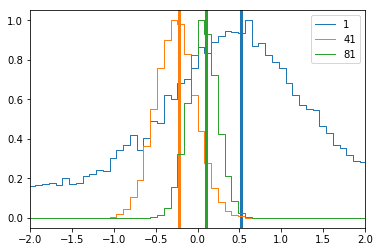

In [7]:
keys = sorted(list(hists.keys()))
for k in keys:
    p = plt.plot(tb.bin_edges_to_center(bins), hists[k][0]/np.max(hists[k][0]), 
                 drawstyle='steps', label=str(k), lw=1)
    c = p[0].get_color()
    plt.axvline(stats[k][3], lw=3, color=c)
    print(k, stats[k][2:5], stats[k][3]/(stats[k][4]-stats[k][2]), )
plt.legend()
plt.xlim((-2,2))

## if both are unknown

In [8]:
# generate some data
bins = np.linspace(-4,4,100)
hists2 = {}
stats2 = {}
hists2d = {}
binsd = np.linspace(0.1,5,100)
for npts in tqdm.tqdm_notebook((1,2,5,10,20,40,60,80,200)):
    d1 = sampledat[np.random.randint(0, len(sampledat), npts)]
    with pm.Model() as model:
        alpha = pm.Uniform('loc', -10, 10)
        beta = pm.Uniform('dist', 0.1, 5)
        x = pm.Cauchy(name='x', alpha=alpha, beta=beta, observed=d1)
        trace = pm.sample(5000, njobs=4)
        hists2[npts] = np.histogram(trace['loc'], bins)
        stats2[npts] = np.percentile(trace['loc'], (1, 5, 25, 50, 75, 95, 99))
        hists2d[npts] = np.histogram2d(trace['loc'], trace['dist'], bins=(bins, binsd))

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3.4882:   2%|▏         | 3833/200000 [00:00<00:20, 9759.01it/s] 
Convergence archived at 4300
Interrupted at 4,300 [2%]: Average Loss = 3.5317
 86%|████████▌ | 4713/5500 [00:10<00:01, 455.19it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.450821503807, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 5500/5500 [00:12<00:00, 449.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 8.7902:   1%|          | 1621/200000 [00:00<00:23, 8430.24it/s]
Convergence archived at 1900
Interrupted at 1,900 [0%]: Average Loss = 8.8188
100%|██████████| 5500/5500 [00:09<00:00, 554.88it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss

1 [-0.87638748  0.42940422  1.7865303 ] 0.161253276923
2 [-6.22819858 -2.43029799  0.01241722] -0.389432399801
5 [-0.20642645  0.54067546  1.48487975] 0.319679226631
10 [ 0.15102688  0.60284002  1.03605127] 0.681156388725
20 [-0.44547043 -0.16023871  0.1144026 ] -0.286205438879
40 [-0.46671259 -0.34532968 -0.22519639] -1.42984067266
60 [ 0.10524593  0.30112477  0.49586904] 0.770883150382
80 [-0.28343135 -0.15883803 -0.02937709] -0.625213022004
200 [-0.18359114 -0.11499465 -0.04617547] -0.836837933137


(-2, 2)

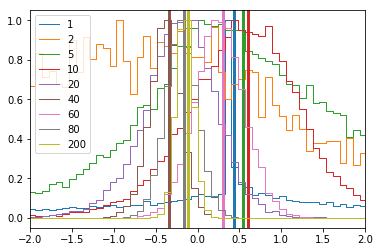

In [9]:
keys = sorted(list(hists2.keys()))
for k in keys:
    p = plt.plot(tb.bin_edges_to_center(bins), hists2[k][0]/np.max(hists2[k][0]), 
                 drawstyle='steps', label=str(k), lw=1)
    c = p[0].get_color()
    plt.axvline(stats2[k][3], lw=3, color=c)
    print(k, stats2[k][2:5], stats2[k][3]/(stats2[k][4]-stats2[k][2]), )
plt.legend()
plt.xlim((-2,2))

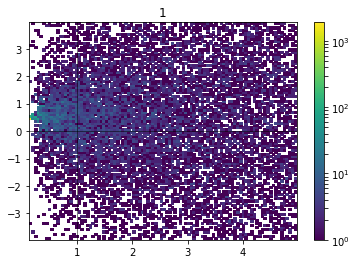

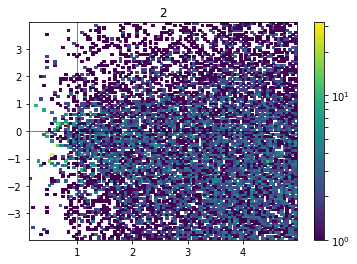

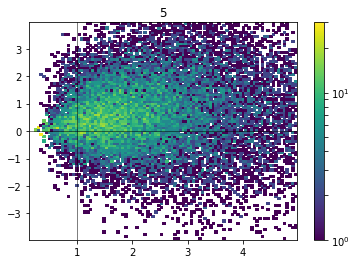

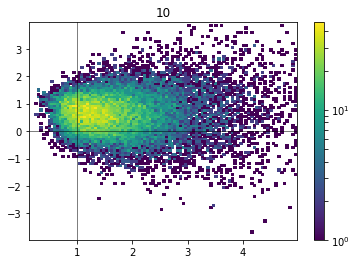

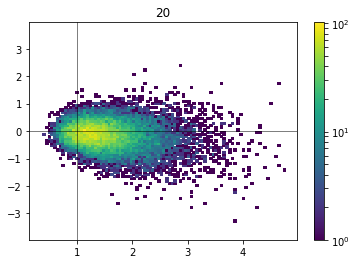

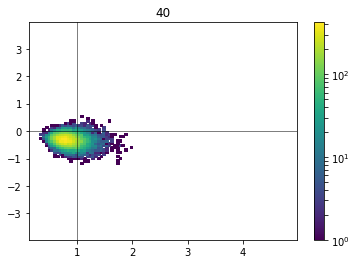

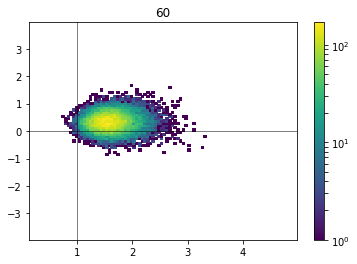

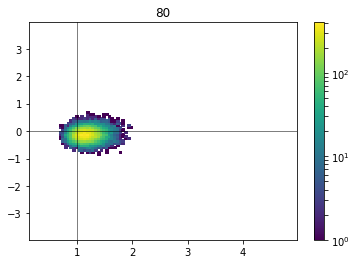

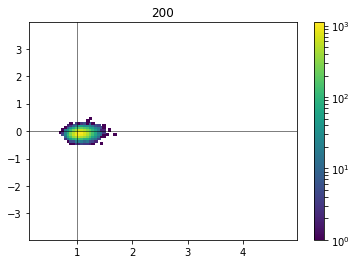

In [10]:
# plt.contour(hists2d[1][0], 5)
from matplotlib.colors import LogNorm

keys = sorted(list(hists2.keys()))
for k in keys:
    plt.figure()
    plt.pcolormesh(tb.bin_edges_to_center(binsd), 
                   tb.bin_edges_to_center(bins),
                   hists2d[k][0], 
                   norm=LogNorm())
    plt.title(str(k))
    plt.colorbar()
    plt.axvline(1, lw=0.5, c='k')
    plt.axhline(0, lw=0.5, c='k')

# Now repeat all this updating the prior with the posterior one count at a time

In [70]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [71]:
# sampledat is the data
dat2 = sampledat.copy().tolist()

In [72]:
# traces = []

with pm.Model() as model:
    data = dat2.pop()
    data = [2.5, 2.5] # start kinda bad
    alpha = pm.Uniform('loc', -10, 10)
    #     beta = pm.Uniform('dist', 1, 1)
    x = pm.Cauchy(name='x', alpha=alpha, beta=1, observed=data)
    trace = pm.sample(5000, njobs=4)
    
traces= [trace]



Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.2028:   3%|▎         | 6348/200000 [00:00<00:19, 10192.21it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 5.7939
100%|██████████| 5500/5500 [00:05<00:00, 1072.70it/s]


(-4, 4)

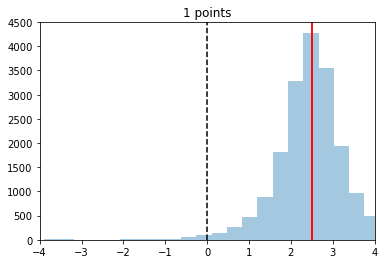

In [73]:
sns.distplot(traces[-1]['loc'][1000:], kde=False)
plt.axvline(0, c='k', linestyle='--')
plt.axvline(data[0], c='r')
plt.axvline(data[1], c='r')
plt.title('{} points'.format(len(traces)))
plt.xlim((-4,4))

In [74]:
alpha
traces[-1].varnames

['loc_interval__', 'loc']

In [75]:

for _ in tqdm.tqdm_notebook(range(20)):
    with pm.Model() as model:
        data = [dat2.pop(), dat2.pop()]
        alpha = from_posterior('loc', trace['loc'])
        x = pm.Cauchy(name='x', alpha=alpha, beta=1, observed=data)
        trace = pm.sample(5000, njobs=4)
        traces.append(trace)


Widget Javascript not detected.  It may not be installed or enabled properly.


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 500
Interrupted at 500 [0%]: Average Loss = 15.323
100%|█████████▉| 5479/5500 [00:11<00:00, 292.12it/s]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [00:11<00:00, 470.51it/s]
/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 3 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 2 contains 8 diverging samples after tuning. If inc

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 5.9139:   4%|▎         | 7180/200000 [00:01<00:31, 6170.98it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 7.7391
100%|██████████| 5500/5500 [00:13<00:00, 407.90it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 700
Interrupted at 700 [0%]: Average Loss = 12.184
100%|██████████| 5500/5500 [00:14<00:00, 383.18it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 100
Interrupted at 100 [0%]: Average Loss = 11.684
  5%|▌         | 283/5500 [00:08<1:59:23,  1.37s/it]/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.88572116961, but should be close to 0.8. Try to increase the number of

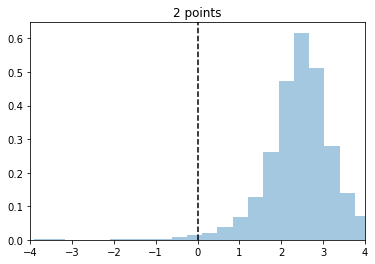

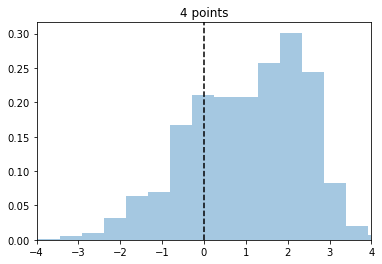

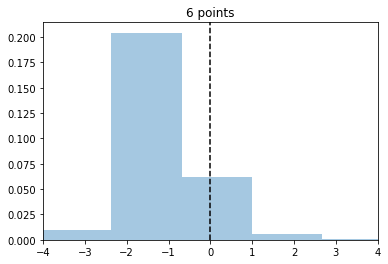

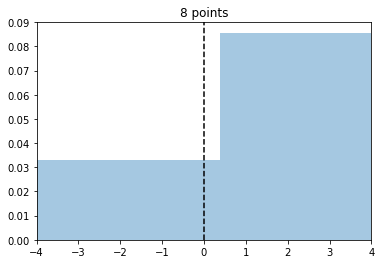

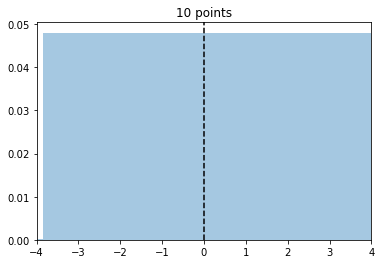

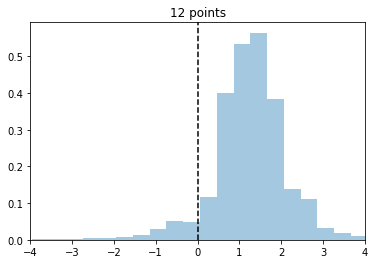

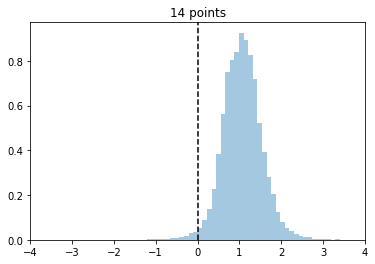

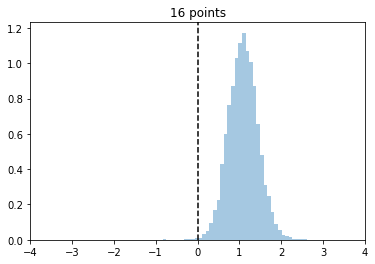

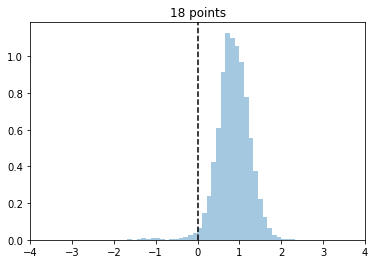

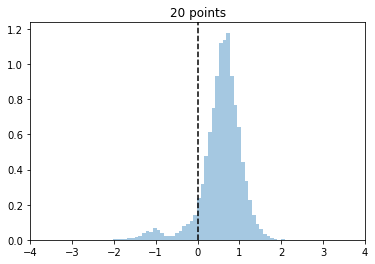

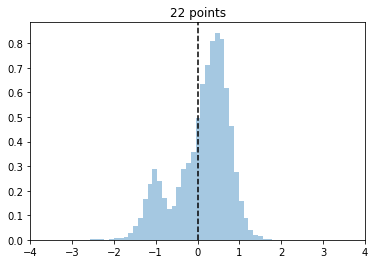

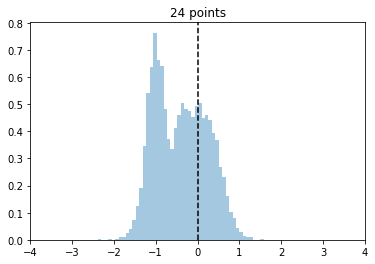

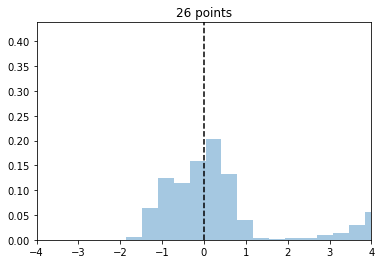

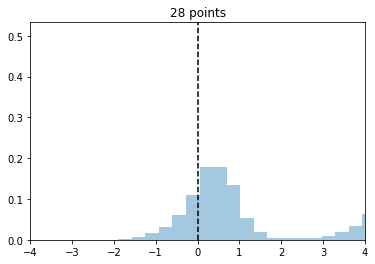

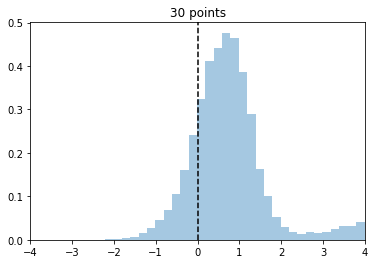

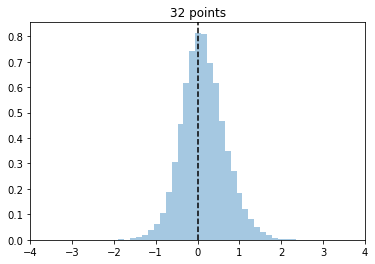

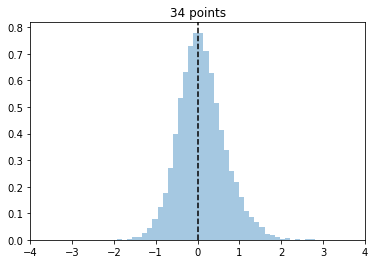

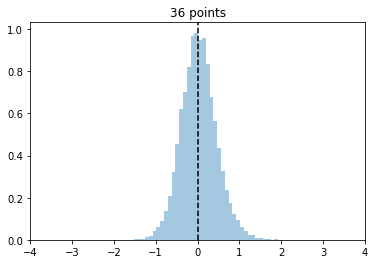

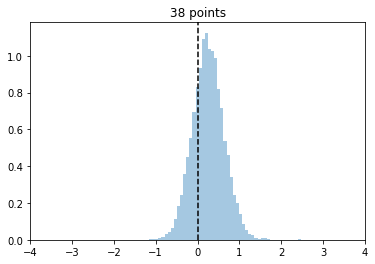

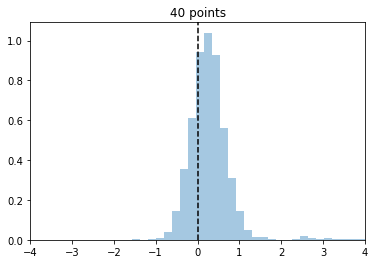

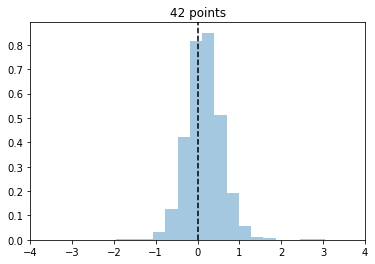

In [76]:
for ii, t in enumerate(traces):
    plt.figure()
    sns.distplot(t['loc'][1000:], kde=False, norm_hist=True)
    plt.axvline(0, c='k', linestyle='--')
    plt.title('{} points'.format((ii+1)*2))
    plt.xlim((-4,4))
    plt.show()


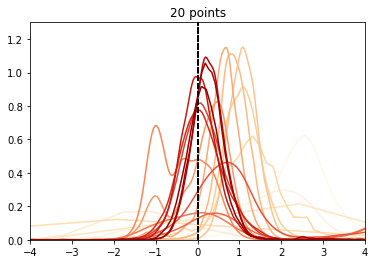

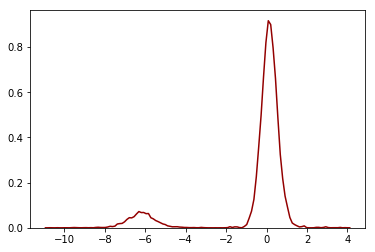

In [89]:

for ii, t in enumerate(traces):
    sns.distplot(t['loc'][1000:], kde=True, hist=False, color=plt.cm.OrRd(ii/len(traces)))
    plt.axvline(0, c='k', linestyle='--')

plt.title('{} points'.format(ii))
plt.xlim((-4,4))
plt.ylim((0, 1.3))
    
plt.figure()
sns.distplot(traces[-1]['loc'][1000:], kde=True, hist=False, color=plt.cm.OrRd(ii/len(traces)))


/Users/balarsen/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


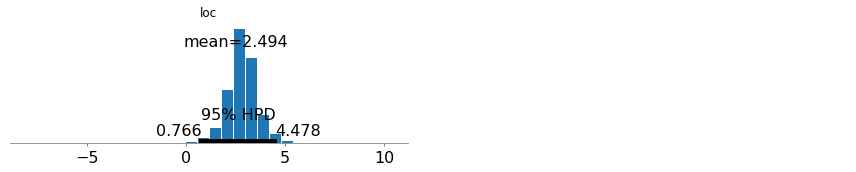

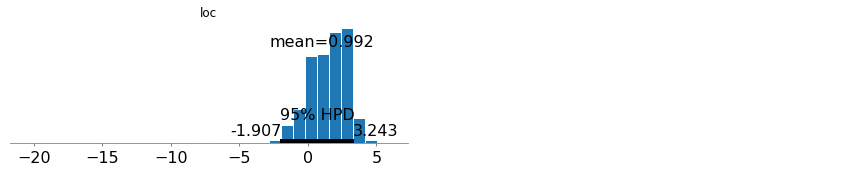

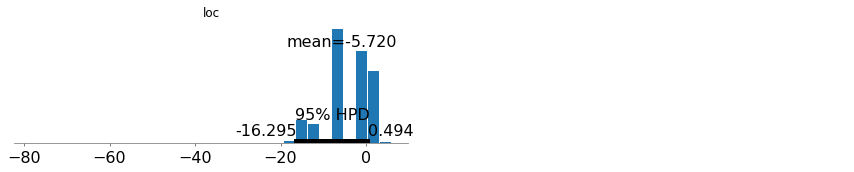

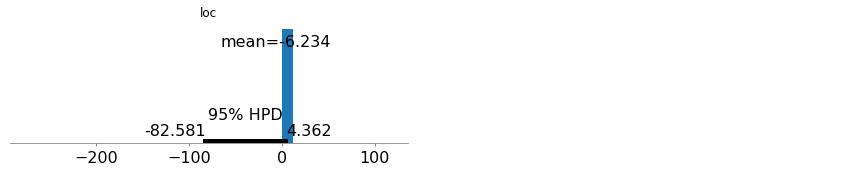

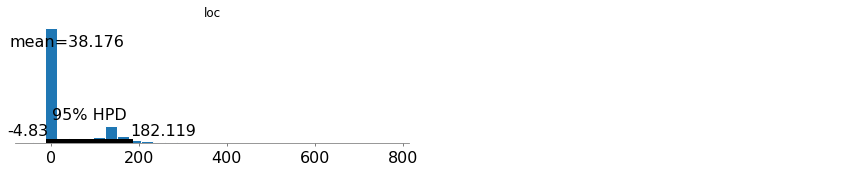

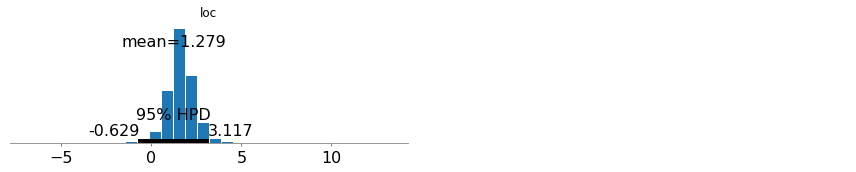

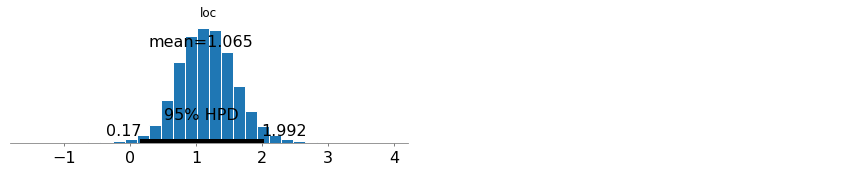

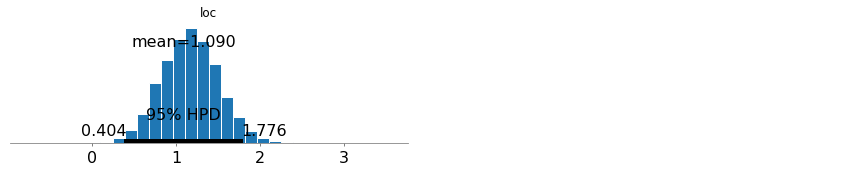

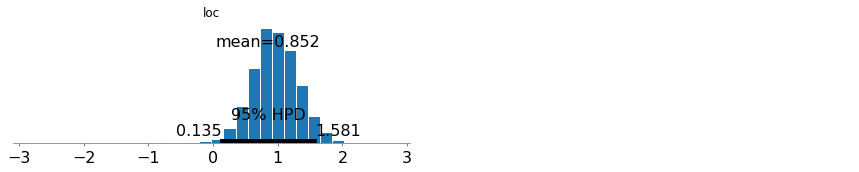

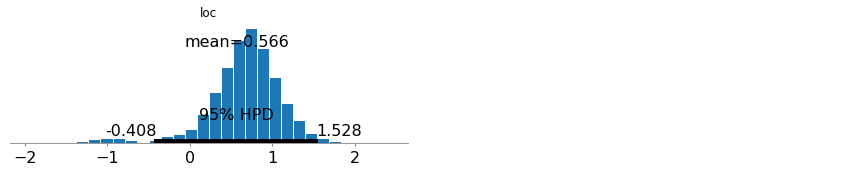

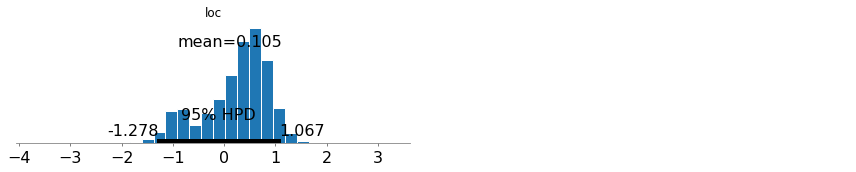

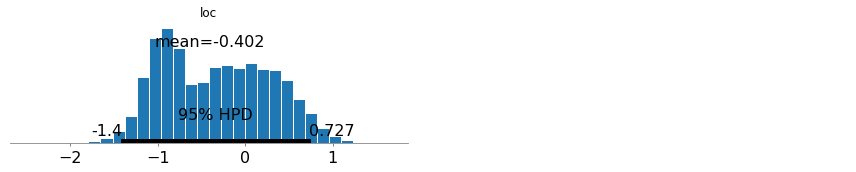

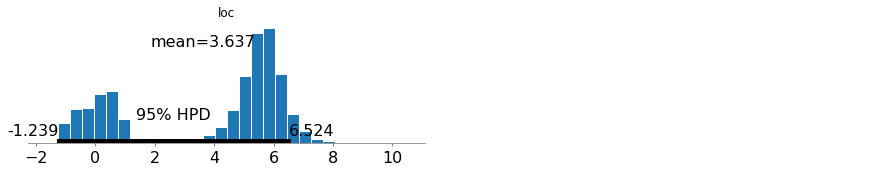

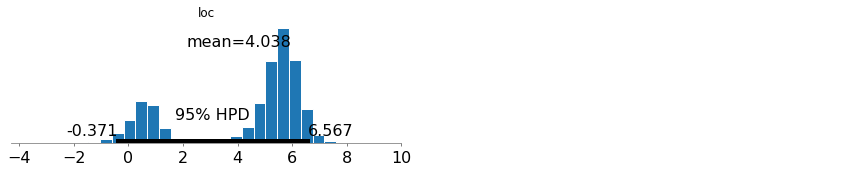

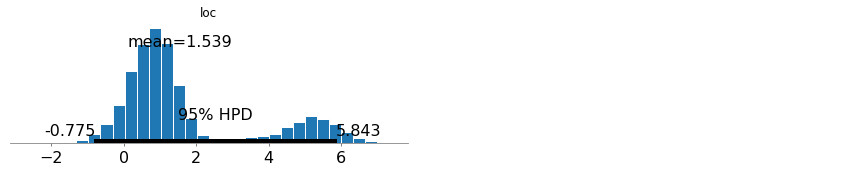

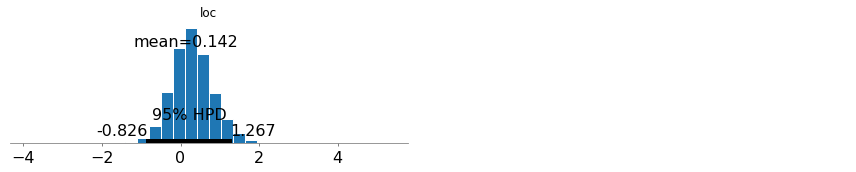

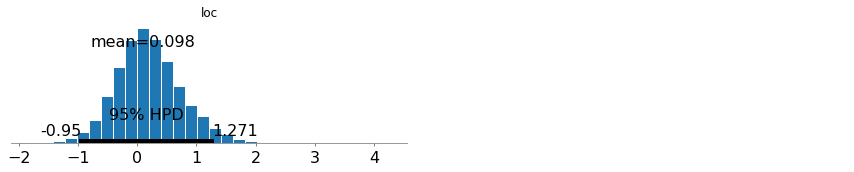

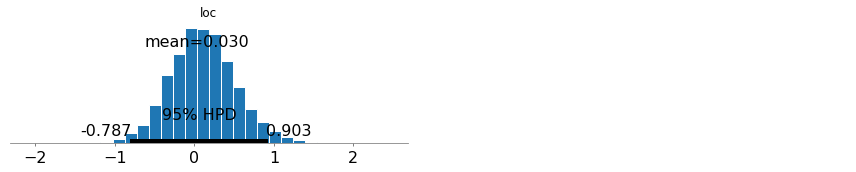

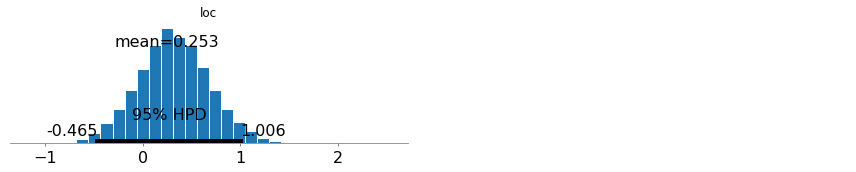

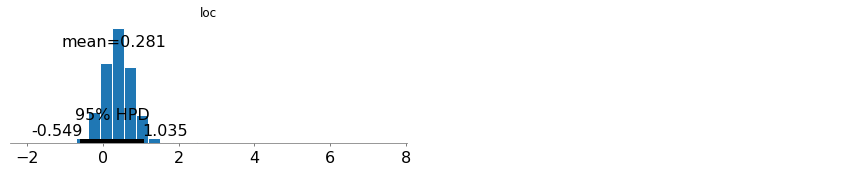

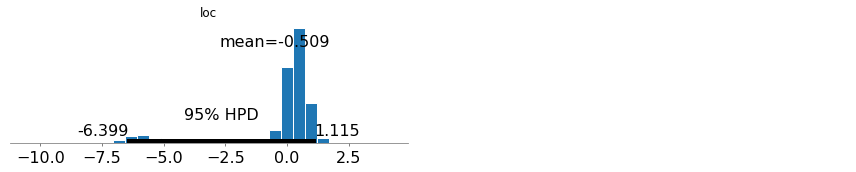

In [84]:
for t in traces:
    pm.plot_posterior(t)

In [100]:
for t in traces:
    print(pm.gelman_rubin(t))

{'loc_interval__': 0.99996663744301417, 'loc': 0.99994885477836859}
{'loc_interval__': 1.0048606258416073, 'loc': 1.0048239254636506}
{'loc_interval__': 2.1103532960135261, 'loc': 2.2464315777764425}
{'loc_interval__': 1.1532067513685325, 'loc': 1.1593239350480522}
{'loc_interval__': 2.2349765629287925, 'loc': 2.3758369626265372}
{'loc_interval__': 1.0002316489071443, 'loc': 1.0002316616447999}
{'loc_interval__': 0.99991719081188968, 'loc': 0.99991712442259395}
{'loc_interval__': 1.0001074735213973, 'loc': 1.0001074465017041}
{'loc_interval__': 1.0001399428076287, 'loc': 1.0001380151893546}
{'loc_interval__': 1.0020656286460974, 'loc': 1.0020656509240329}
{'loc_interval__': 1.0007878949962328, 'loc': 1.0007867834095048}
{'loc_interval__': 1.0002665101586494, 'loc': 1.0002665743731403}
{'loc_interval__': 1.1115602235522879, 'loc': 1.1135759351356727}
{'loc_interval__': 1.0270771025715157, 'loc': 1.0270809459211481}
{'loc_interval__': 1.0011445338046085, 'loc': 1.0011444710097737}
{'loc_

# How does the posterior compare to just riunning N points?

In [85]:
# traces = []

with pm.Model() as model:
    alpha = pm.Uniform('loc', -10, 10)
    #     beta = pm.Uniform('dist', 1, 1)
    x = pm.Cauchy(name='x', alpha=alpha, beta=1, observed=sampledat[:42])
    trace = pm.sample(5000, njobs=4)
    



Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 98.141:   4%|▍         | 8693/200000 [00:00<00:17, 10793.28it/s]
Convergence archived at 8900
Interrupted at 8,900 [4%]: Average Loss = 109.06
100%|██████████| 5500/5500 [00:04<00:00, 1170.42it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x14774b3c8>], dtype=object)

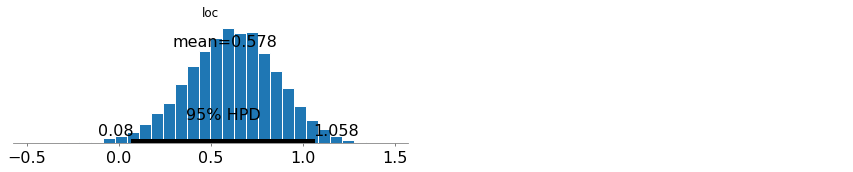

In [86]:
pm.plot_posterior(trace)

(0, 1.3)

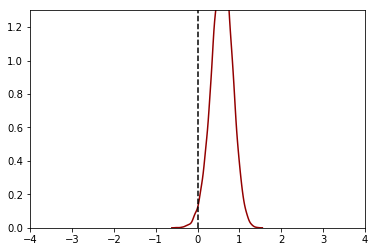

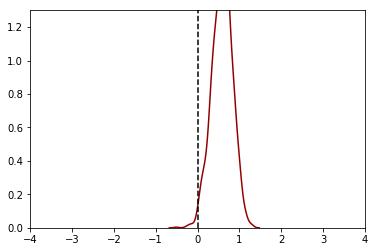

In [93]:

sns.distplot(trace['loc'][1000:], kde=True, hist=False, color=plt.cm.OrRd(ii/len(traces)))
plt.axvline(0, c='k', linestyle='--')

plt.xlim((-4,4))
plt.ylim((0, 1.3))
    
plt.figure()
sns.distplot(trace['loc'][1000::10], kde=True, hist=False, color=plt.cm.OrRd(ii/len(traces)))
plt.axvline(0, c='k', linestyle='--')

plt.xlim((-4,4))
plt.ylim((0, 1.3))



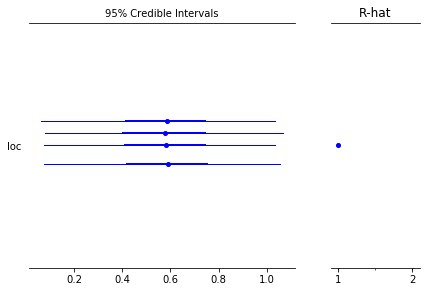

In [90]:
pm.forestplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14221e080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x140fd2550>]], dtype=object)

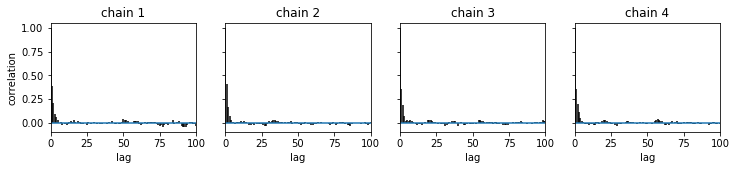

In [91]:
pm.autocorrplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f1fa860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14032c2e8>]], dtype=object)

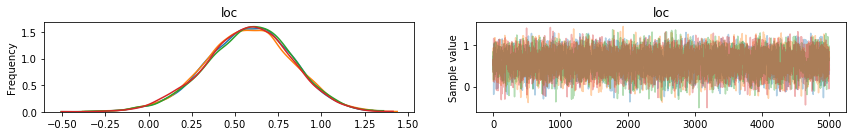

In [96]:
pm.traceplot(trace)

In [98]:
pm.gelman_rubin(trace)


{'loc': 0.99999517022501971, 'loc_interval__': 0.99999506182861053}

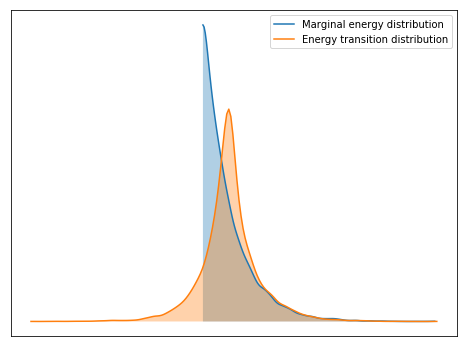

In [101]:
pm.energyplot(trace)

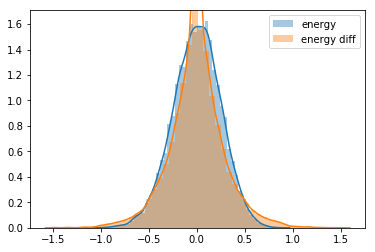

In [103]:

energy = trace['loc']
energy_diff = np.diff(energy)
sns.distplot(energy - energy.mean(), label='energy')
sns.distplot(energy_diff, label='energy diff')
plt.legend()